In [1]:
import matplotlib.pyplot as plt
import numpy as np
from transformers import BertTokenizer, BertForSequenceClassification, BertConfig
from helpers.twitter_data_loader import TwitterDataset,padding_collate_fn,idx2cat, cat2idx
from models.RNN import RNN
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay 
import random as rng

In [10]:
"""
Optionally run on CUDA as discussed in https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
"""
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
pretrained = 'bert-base-multilingual-cased'
tokenizer = BertTokenizer.from_pretrained(pretrained)
tokenizer.do_basic_tokenize = False

In [4]:
test_dataset = TwitterDataset("data/test_merged.csv", tokenizer)

396153it [02:22, 2773.81it/s]
c:\Users\joshu\OneDrive\Coding\HMC\lt_project\git\LTP_Final\helpers\twitter_data_loader.py:59: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.data = np.array(data)


In [5]:
test_dat = DataLoader(test_dataset,
		collate_fn=padding_collate_fn,
		batch_size = 32,
        shuffle=False)

In [15]:
model = torch.load("RNN_500_0.1.pt")
torch.save(model.module.state_dict(), "state_dict_RNN.pt")
model = RNN(input_dim=tokenizer.vocab_size, output_dim=5,
			gru_dim=500,dropout_prob=0.1)
model.load_state_dict(torch.load("state_dict_RNN.pt", map_location=device))

<All keys matched successfully>

In [16]:
# Copy of the evaluation loop used to train the RNN
model.to(device)
model.eval()
total_pred = []
with torch.no_grad():
    correct = 0
    total = 0
    for batch in test_dat:
        val_data, val_labels = batch
        val_data = val_data.to(device)
        output_val = model(val_data)
        output_val_classes = torch.max(output_val, dim=1).indices
        if not device == "cpu":
            output_val_classes = output_val_classes.cpu()
        for p in output_val_classes:
            total_pred.append(p.item())

        correct += torch.sum(output_val_classes == val_labels).detach().numpy()
        total += len(val_labels)
print(correct/total)

0.8440649043801369


{0, 1, 2, 3, 4}
{0, 1, 2, 3, 4}


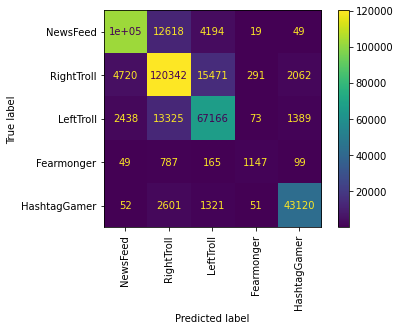

In [17]:
print(set(total_pred))
print(set(test_dataset.labels))
cnf = confusion_matrix(test_dataset.labels,np.array(total_pred))
disp = ConfusionMatrixDisplay(cnf,display_labels=idx2cat)
disp.plot(xticks_rotation="vertical")

In [18]:
padded_pred = total_pred[:]
padded_pred.insert(0,0)
padded_labels = list(test_dataset.labels)
padded_labels.insert(0,0)

In [19]:
import csv
rng.seed(0)
with open("data/test_merged.csv", newline="", encoding='utf8') as data_file:
    reader = csv.reader(data_file, delimiter=",")
    for index,(pred,obs,cont) in enumerate(zip(padded_pred,padded_labels,reader)):
        if index ==0:
            continue
        chance = rng.random()
        if pred == 1 and obs == 2: # pred right troll observed left
            if chance < 0.01:
                print(f"Predicted Right-troll for Left-troll tweet: {cont[1]}")
        elif pred == 2 and obs == 1: # pred left troll observed right
            if chance < 0.01:
                print(f"Predicted Left-troll for Right-troll tweet: {cont[1]}")

5kypSnsD5A
Predicted Right-troll for Left-troll tweet: BREAKING: Rubio sometimes forgets to floss. #NYTHeadlines @Soldier1eaODGrn @nytimes
Predicted Left-troll for Right-troll tweet: .@itsmarlamaples taking smiling selfies in front of the car that ran over 20people. How does it feel to be a heartless monster? #TimesSquare https://t.co/57OeeW8u4O
Predicted Left-troll for Right-troll tweet: On this day in #AirForce #History https://t.co/J5AWNbhbyX
Predicted Left-troll for Right-troll tweet: Blackwater Heads to China https://t.co/abUUCAF6ji
Predicted Right-troll for Left-troll tweet: With 15:49 left in the second half, Mountain Hawks have opened a 40-28 lead following a Kempton three-point play.
Predicted Left-troll for Right-troll tweet: Aisha was sexy even when she was 9 yr-old! Women are ready for sex as soon as they are sexy! https://t.co/DHYfz2yoH8
Predicted Left-troll for Right-troll tweet: Dear Media, It's About The Spying, Stupid #ObamaGate #spying is being exposed  https://t.co/f